<a href="https://colab.research.google.com/github/MSDreamLab/anomalib-bent-wire/blob/main/Bent%20wire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!pip install openvino-colab
!pip install openvino
!pip install openvino-dev[pytorch,cafee,kaldi,mxnet,tensorflow2,onnx]

In [106]:
!pip install GitPython
!pip install onnx
!pip install tensorflow
!pip install torchtext

In [107]:
!git clone https://github.com/openvinotoolkit/anomalib.git
%cd anomalib
%pip install .

Cloning into 'anomalib'...
remote: Enumerating objects: 33488, done.
remote: Counting objects: 100% (3967/3967), done.
remote: Compressing objects: 100% (2329/2329), done.
remote: Total 33488 (delta 2302), reused 2666 (delta 1542), pack-reused 29521
Receiving objects: 100% (33488/33488), 1.51 GiB | 21.47 MiB/s, done.
Resolving deltas: 100% (18881/18881), done.
/content/anomalib/anomalib/anomalib/anomalib/anomalib
Processing /content/anomalib/anomalib/anomalib/anomalib/anomalib
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for anomalib: filename=anomalib-1.0.0.dev0-py3-none-any.whl size=377718 sha256=e6563bd44d3e96c5e0134e815ec6f9e6626b7c751414ea24a43c58b803cdb258
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2s3pb8b/wheels/0d/c3/63/55bd41327ba2335fa1f02804f7d5ac3c9b88dc1500d6cecf86
Successfully built anomalib
  Attempting uninstall: anomalib
    Found existing installation: ano

In [108]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)

In [109]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

In [110]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: mvtec
  format: mvtec
  path: ./datasets/MVTec
  category: bottle
  task: segmentation
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  nam

In [111]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)

/usr/local/lib/python3.10/dist-packages/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [112]:
config['dataset']['category'] = 'cable'

In [113]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

mvtec: 5.26GB [03:44, 23.5MB/s]                            
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


In [114]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


/usr/local/lib/python3.10/dist-packages/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


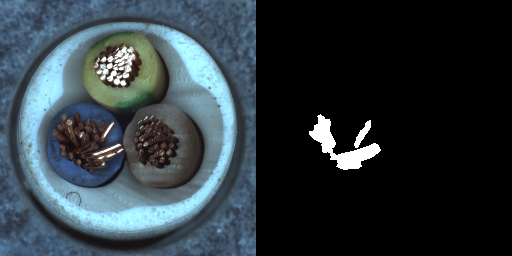

In [115]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))

# Visualize an image with a mask
show_image_and_mask(data, index=0)

In [116]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"

# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [117]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at

In [118]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8324588537216187     │
│       image_F1Score       │    0.8240740895271301     │
│        pixel_AUROC        │    0.9530256390571594     │
│       pixel_F1Score       │    0.39722827076911926    │
└───────────────────────────┴───────────────────────────┘

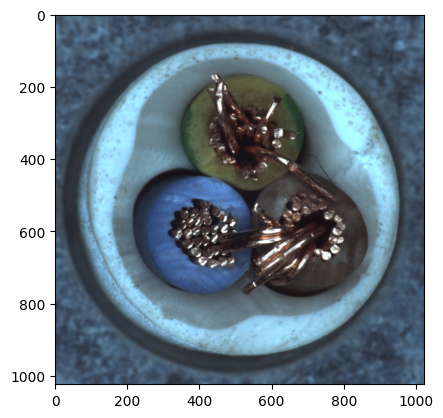

In [119]:
image_path = root_directory / "datasets/MVTec/cable/test/bent_wire/012.png"
image = read_image(path="./datasets/MVTec/cable/test/bent_wire/012.png")
plt.imshow(image)

In [120]:
output_path = Path(config["project"]["path"])
print(output_path)

results/padim/mvtec/bottle/run


In [121]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata.exists())

True True


In [122]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

In [123]:
print(image.shape)

(1024, 1024, 3)


In [124]:
predictions = inferencer.predict(image=image)

In [125]:
print(predictions.pred_score, predictions.pred_label)

0.8144659105921676 True


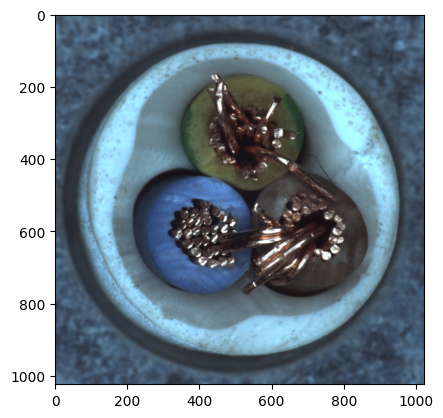

In [126]:
# Visualize the original image
plt.imshow(predictions.image)


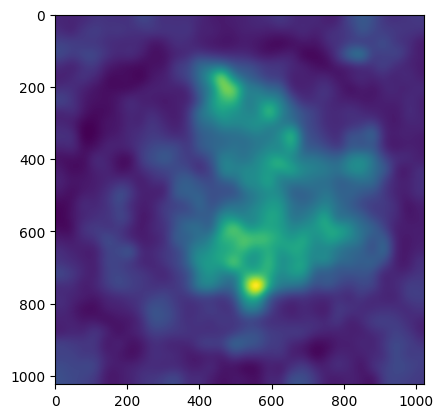

In [127]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

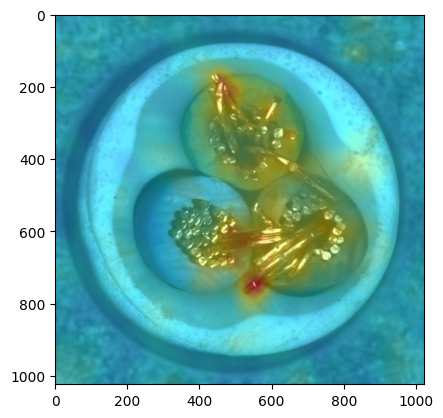

In [128]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

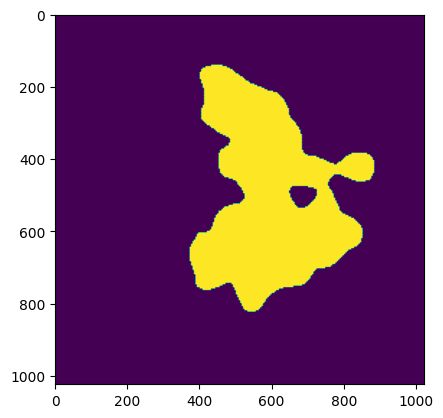

In [129]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

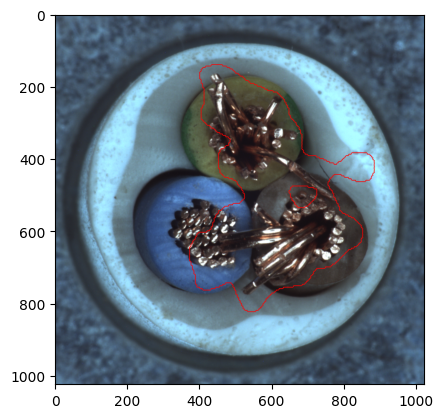

In [130]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)